In [34]:
import numpy as np
import torch
from torch import nn
import tqdm

In [35]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


--Data Initialization--

106
12
40


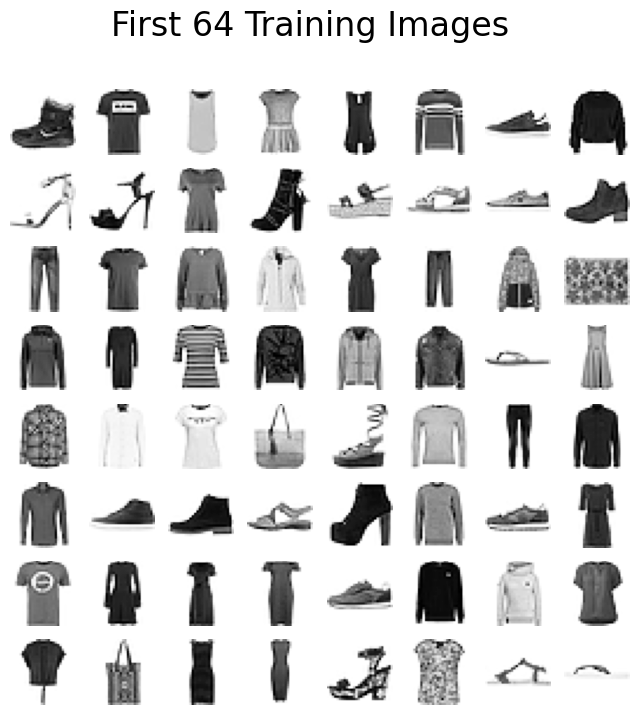

In [36]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# Convert to arrays for classifiers to apply
fashion_train_images = train_dataset.data.numpy().reshape(len(train_dataset), -1)  # (60000, 784)
fashion_test_images = test_dataset.data.numpy().reshape(len(test_dataset), -1)     # (10000, 784)

fashion_train_labels = train_dataset.targets.numpy()
fashion_test_labels = test_dataset.targets.numpy()

# Use the following code to create a validation set of 10%
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


# Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")



# Sample code to plot N^2 images from the dataset
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

    

## Task 1: Define Fully Connected Neural Network (FCNs)

In [37]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden_layers, dropout_rate=0, init_type=None, use_bn=False): 
        super(ACAIGFCN, self).__init__()
        self.use_bn = use_bn
        self.dropout = nn.Dropout(dropout_rate)
        #Define the network layer(s) and activation function(s)
        self.input_layer = nn.Linear(input_dim, hidden_layers[0])
        self.input_bn = nn.BatchNorm1d(hidden_layers[0]) if use_bn else None

        self.hidden_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            if use_bn:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i + 1]))
        self.output_layer = nn.Linear(hidden_layers[-1], output_dim)
        self.initialize_weights(init_type)

    def initialize_weights(self, init_type):
        for layer in [self.input_layer] + list(self.hidden_layers) + [self.output_layer]:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_normal_(layer.weight)
                elif init_type == 'kaiming':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                elif init_type == 'normal':
                    nn.init.normal_(layer.weight, mean=0, std=0.1)
                layer.bias.data.fill_(0.01)
 
    def forward(self, input):
        #Define how your model propagates the input through the network
        input = input.view(input.shape[0], -1)
        x = self.input_layer(input)
        if self.use_bn:
            x = self.input_bn(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)  # Apply dropout
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            if self.use_bn:
                x = self.bn_layers[i](x)
            x = torch.nn.functional.relu(x)
            x = self.dropout(x)  # Apply dropout

        output = self.output_layer(x)
        
        return output


In [52]:
def train_and_evaluate_FCN(train_batches, val_batches, test_batches, 
                           input_dim=784, output_dim=10, hidden_layers=[256, 128, 64], 
                           init_type=None, dropout_rate=0,
                           learning_rate=0.05, epochs=75, optimizer_type="SGD",
                           use_bn=False, track_val_loss=False):

    # Initialize model
    model = ACAIGFCN(input_dim=input_dim, output_dim=output_dim, 
                      hidden_layers=hidden_layers, dropout_rate=dropout_rate, 
                      init_type=init_type, use_bn=use_bn)
    
    loss_func = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_type == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_type == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Error! Choose from 'SGD', 'RMSprop', or 'Adam'.")

    # Tracking loss and accuracy
    train_loss_list = np.zeros((epochs,))
    val_acc_list = np.zeros((epochs,))
    val_loss_list = np.zeros((epochs,)) if track_val_loss else None

    # Training loop
    for epoch in tqdm.trange(epochs):
        # ACAIGFCN Training 
        epoch_loss = 0.0
        for train_features, train_labels in train_batches:
            # Set model into training mode
            model.train()
            
            # Reshape images into a vector
            train_features = train_features.reshape(-1, 28*28)

            # Reset gradients, Calculate training loss on model 
            optimizer.zero_grad()
            outputs = model(train_features)
            loss = loss_func(outputs, train_labels)

            # Perfrom optimization, back propagation
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss for the epoch
            epoch_loss += loss.item()

    
        # Record loss for the epoch
        train_loss_list[epoch] = epoch_loss / len(train_batches)
        # print('Epoch {}, loss {}'.format(epoch, loss.item()))

        # ACAIGFCN Validation
        correct_predictions = 0
        total_samples = 0
        val_loss = 0.0 if track_val_loss else None
        for val_features, val_labels in val_batches:
            
            # Telling PyTorch we aren't passing inputs to network for training purpose
            with torch.no_grad(): 
                model.eval()
                
                # Reshape validation images into a vector
                val_features = val_features.reshape(-1, 28*28)
            
                # Compute validation outputs (targets) and compute accuracy 
                validation_outputs = model(val_features)

            # Compute accuracy in a concise manner
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).float()
            
            # Accumulate correct predictions and total samples
            correct_predictions += correct.sum().item()
            total_samples += val_labels.size(0)

            if track_val_loss:
                val_loss += loss_func(validation_outputs, val_labels).item()

        # Compute and record validation accuracy
        val_acc_list[epoch] = correct_predictions / total_samples
                
        # Record accuracy for the epoch; print training loss, validation accuracy
        # print(f"Epoch: {epoch}; Validation Accuracy: {val_acc_list[epoch] * 100:.2f}%")
        if track_val_loss:
            val_loss_list[epoch] = val_loss / len(val_batches)

    #Calculate accuracy on test set

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        test_correct = 0
        total_test = 0
        batch_accs = []
        for test_features, test_labels in test_batches:

            model.eval()
            # Reshape test images into a vector
            test_features = test_features.reshape(-1, 28*28)

            # Compute validation outputs (targets) 
            test_outputs = model(test_features)
            correct1 = (torch.argmax(test_outputs, dim=1) == test_labels).float()
            batch_acc = correct1.mean().item()  # Accuracy for this batch
            batch_accs.append(batch_acc)
            
            # Accumulate correct predictions and total samples
            test_correct += correct1.sum().item()
            total_test += test_labels.size(0)
        
        # Compute total (mean) accuracy
        test_acc = test_correct / total_test
        test_acc_std = np.std(batch_accs)
        
        # Report total (mean) accuracy, can also compute std based on batches
        # print(f"Test Accuracy: {test_acc} ± {test_acc_std:.4f}")
            
    if track_val_loss:
        return train_loss_list, val_acc_list, (test_acc, test_acc_std), val_loss_list
    else:
        return train_loss_list, val_acc_list,  (test_acc, test_acc_std)

### --Plotting Functions--

In [39]:
import matplotlib.pyplot as plt
# Plot training loss and validation accuracy for multiple parameters
def plot_param(train_loss_curves, val_acc_curves, param_values, name, param_name, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, val in enumerate(param_values):
        plt.plot(train_loss_curves[i], linewidth=3, label=f"{param_name} = {val}")
    plt.xlabel("Epoch", fontdict=dict(size=15))
    plt.ylabel("Training Loss", fontdict=dict(size=15))
    plt.title("Training Loss", fontdict=dict(size=17))
    plt.legend(fontsize=12)

    plt.subplot(1, 2, 2)
    for i, val in enumerate(param_values):
        plt.plot(val_acc_curves[i] * 100, linewidth=3, label=f"{param_name} = {val}")
    plt.xlabel("Epoch", fontdict=dict(size=15))
    plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
    plt.title("Validation Accuracy", fontdict=dict(size=17))
    plt.legend(fontsize=12)
    plt.suptitle(f"{title}", fontsize=21)
    plt.tight_layout()
    plt.savefig(f'Figure {name}_{param_name}.pdf')
    plt.show()

# Plot training and validation loss for multiple parameters
def plot_train_val_loss(train_loss, val_acc, val_loss, param_values, name, param_name, title):
    plt.figure(figsize=(12, 5))
    # Subplot 1: Training Loss & Validation Loss
    plt.subplot(1, 2, 1)
    for i, val in enumerate(param_values):
        plt.plot(train_loss[i], linewidth=3, linestyle="-", label=f"Train Loss {param_name}={val}")
        plt.plot(val_loss[i], linewidth=3, linestyle="--", label=f"Val Loss {param_name}={val}")
    plt.xlabel("Epochs", fontdict=dict(size=15))
    plt.ylabel("Loss", fontdict=dict(size=15))
    plt.title("Training vs. Validation Loss", fontdict=dict(size=17))
    plt.legend(fontsize=12)
    # Subplot 2: Validation Accuracy
    plt.subplot(1, 2, 2)
    for i, val in enumerate(param_values):
        plt.plot(val_acc[i] * 100, linewidth=3, label=f"{param_name}={val}")
    plt.xlabel("Epochs", fontdict=dict(size=15))
    plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
    plt.title("Validation Accuracy", fontdict=dict(size=17))
    plt.legend(fontsize=12)
    plt.suptitle(f"{title}", fontsize=21)
    plt.tight_layout()
    plt.savefig(f'Figure {name}_{param_name}.pdf')
    plt.show()

# Plot training loss and validation accuracy
def plot_train_loss_val_acc(train_loss_list, val_acc_list, val_loss_list, name, param_name, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, linewidth=3, color='b', label="Training Loss")
    plt.plot(val_loss_list, linewidth=3, linestyle="--", color='g', label=f"Validation Loss")
    plt.xlabel("Epoch", fontdict=dict(size=15))
    plt.ylabel("Training Loss", fontdict=dict(size=15))
    plt.title("Training vs. Validation Loss", fontdict=dict(size=16))
    plt.legend(fontsize=12)
    plt.subplot(1, 2, 2)
    plt.plot(val_acc_list * 100, linewidth=3, color='purple', label="Validation Accuracy")
    plt.xlabel("Epoch", fontdict=dict(size=15))
    plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
    plt.title("Validation Accuracy", fontdict=dict(size=16))
    plt.legend(fontsize=12)
    plt.suptitle(f"{title}", fontsize=21)
    plt.tight_layout()
    plt.savefig(f'Figure {name}_{param_name}.pdf')
    plt.show()

### --Function for testing different parameters--

In [40]:
# Run training and evaluation for different parameters.
def run_param(train_batches, val_batches, test_batches, param_name, param_values,
                    input_dim=784, output_dim=10, hidden_layers=[256,128,64],
                    init_type=None, learning_rate=0.05, dropout_rate=0,
                    epochs=50, optimizer_type="SGD", use_bn=False, track_val_loss=False):
    
    train_loss_list = []
    val_acc_list = []
    test_acc_list = []
    val_loss_list = [] if track_val_loss else None
    test_std_list = []
    
    for val in param_values:
        print(f"\nRunning experiment with {param_name} = {val}")
        kwargs = {
            "input_dim": input_dim,
            "output_dim": output_dim,
            "hidden_layers": hidden_layers,
            "init_type": init_type,
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "optimizer_type": optimizer_type,
            "use_bn": use_bn,
            "track_val_loss": track_val_loss
        }
        kwargs[param_name] = val
        results = train_and_evaluate_FCN( train_batches, val_batches, test_batches, **kwargs)
        if track_val_loss:
            train_loss, val_acc, test_info, val_loss = results
            val_loss_list.append(val_loss)
        else:
            train_loss, val_acc, test_info = results
        test_acc, test_std = test_info
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        test_std_list.append(test_std)

    if track_val_loss:
        return train_loss_list, val_acc_list, test_acc_list, val_loss_list, test_std_list
    else:
        return train_loss_list, val_acc_list, test_acc_list, test_std_list

## Task 2: Baseline Configuration

In [24]:
train_loss_list, val_acc_list, test_info, val_loss_list = train_and_evaluate_FCN(train_batches, val_batches, test_batches, 
                           input_dim=784, output_dim=10, hidden_layers=[256, 128, 64], 
                           init_type=None, optimizer_type="SGD", dropout_rate=0,
                           learning_rate=0.05, epochs=75, track_val_loss=True)
test_acc, test_std = test_info

print(f"Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")

100%|██████████| 75/75 [04:08<00:00,  3.31s/it]


Test Accuracy: 0.8881 ± 0.0217


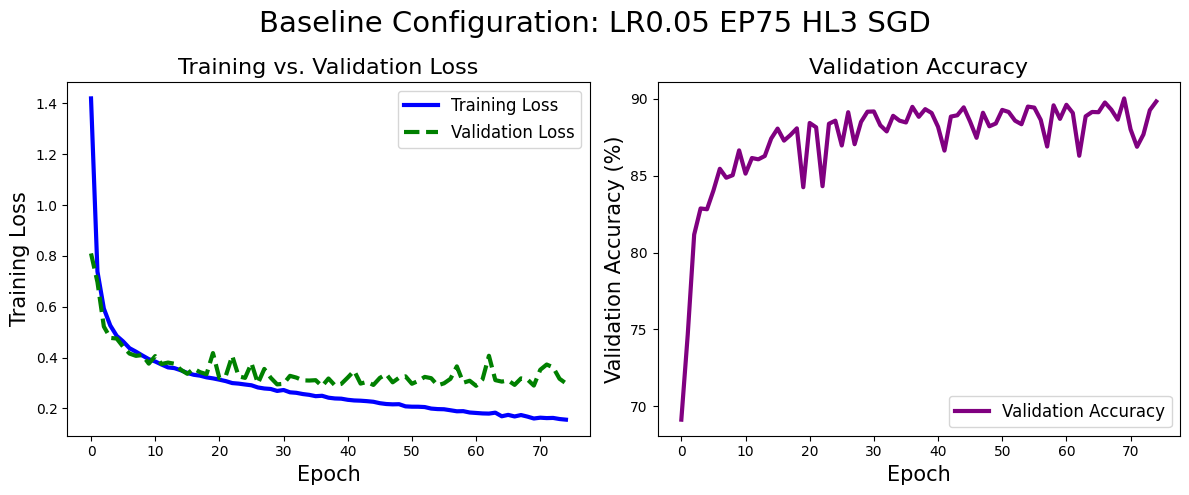

In [25]:
plot_train_loss_val_acc(train_loss_list, val_acc_list, val_loss_list,
                        'BASELINE', 'LR0.05 EP75 HL3 SGD', 'Baseline Configuration: LR0.05 EP75 HL3 SGD')

## Task 3.1: Different Optimizers with Different Learning Rates

In [ ]:
# optimizers = ["SGD", "RMSprop", "Adam"]

# # Run experiments for different optimizer

# train_loss_optms, val_acc_optms, test_acc_optms = run_param(
#     train_batches, val_batches, test_batches, 
#     param_name="optimizer_type", param_values=optimizers, 
#     dropout_rate=0, learning_rate=0.001,
#     epochs=75, hidden_layers=[256, 128, 64])

# print(f"\nTest Accuracies for {optimizers}:")
# for optm, test_acc in zip(optimizers, test_acc_optms):
#     print(f"Optimizer {optm}: Test Accuracy = {test_acc * 100:.2f}%")


Running experiment with optimizer_type = SGD


100%|██████████| 75/75 [03:30<00:00,  2.80s/it]



Running experiment with optimizer_type = RMSprop


100%|██████████| 75/75 [03:35<00:00,  2.87s/it]



Running experiment with optimizer_type = Adam


100%|██████████| 75/75 [03:32<00:00,  2.84s/it]



Test Accuracies for ['SGD', 'RMSprop', 'Adam']:
Optimizer SGD: Test Accuracy = 76.33%
Optimizer RMSprop: Test Accuracy = 88.53%
Optimizer Adam: Test Accuracy = 88.85%


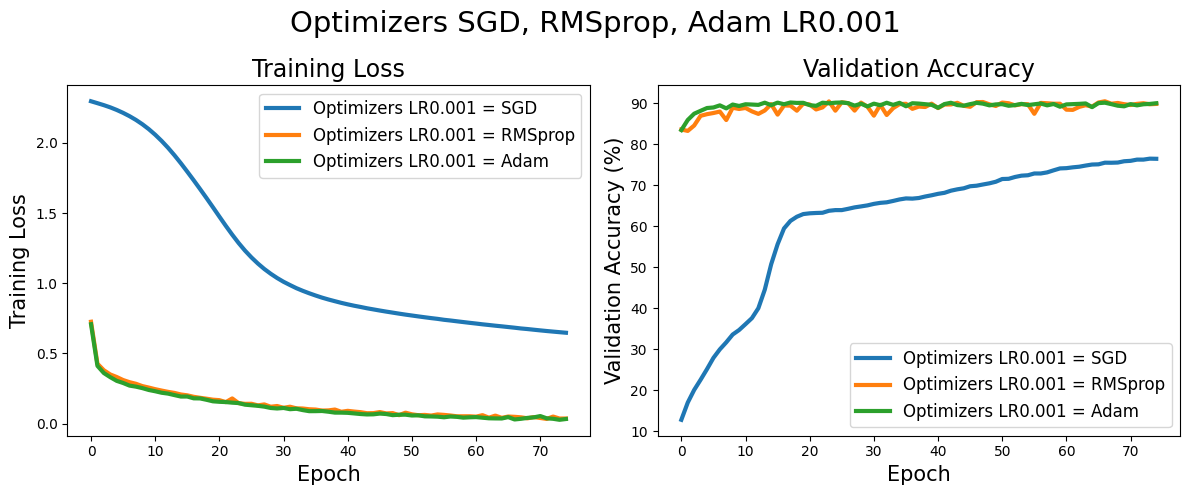

In [ ]:
# plot_param(train_loss_optms, val_acc_optms, optimizers, "OPTM", "Optimizers LR0.001", "Optimizers SGD, RMSprop, Adam LR0.001")

In [9]:
lr_optmS = [0.03, 0.025, 0.01]
optimizerS = "SGD"

# Run experiments for SGD optimizer

print(f"\n Running experiments for optimizer: {optimizerS}")

train_loss_optmS, val_acc_optmS, test_acc_optmS, test_std_optmS = run_param(
    train_batches, val_batches, test_batches, 
    param_name="learning_rate", param_values=lr_optmS, dropout_rate=0,
    optimizer_type=optimizerS, epochs=75, hidden_layers=[256, 128, 64])

print(f"\nTest Accuracies for {optimizerS}:")
for lr, test_acc, test_std in zip(lr_optmS, test_acc_optmS, test_std_optmS):
    print(f"Learning Rate {lr}: Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")


 Running experiments for optimizer: SGD

Running experiment with learning_rate = 0.03


100%|██████████| 75/75 [03:54<00:00,  3.12s/it]



Running experiment with learning_rate = 0.025


100%|██████████| 75/75 [03:49<00:00,  3.05s/it]



Running experiment with learning_rate = 0.01


100%|██████████| 75/75 [03:51<00:00,  3.08s/it]



Test Accuracies for SGD:
Learning Rate 0.03: Test Accuracy: 0.8796 ± 0.0245
Learning Rate 0.025: Test Accuracy: 0.8818 ± 0.0185
Learning Rate 0.01: Test Accuracy: 0.8617 ± 0.0246


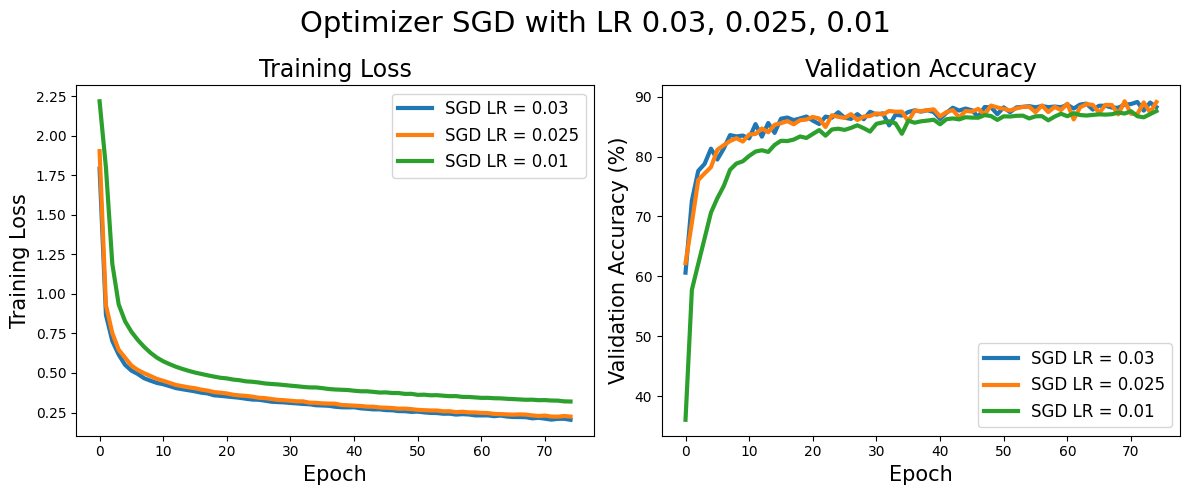

In [111]:
plot_param(train_loss_optmS, val_acc_optmS, lr_optmS, "OPTM", f"{optimizerS} LR", "Optimizer SGD with LR 0.03, 0.025, 0.01")

In [13]:
lr_optmR = [0.005, 0.003, 0.001]
optimizerR = "RMSprop"

# Run experiments for RMSprop optimizer
print(f"\n Running experiments for optimizer: {optimizerR}")

train_loss_optmR, val_acc_optmR, test_acc_optmR, test_std_optmR = run_param(
    train_batches, val_batches, test_batches, 
    param_name="learning_rate", param_values=lr_optmR, dropout_rate=0,
    optimizer_type=optimizerR, epochs=75, hidden_layers=[256, 128, 64])

print(f"\nTest Accuracies for {optimizerR}:")
for lr, test_acc, test_std in zip(lr_optmR, test_acc_optmR, test_std_optmR):
    print(f"Learning Rate {lr}: Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")


 Running experiments for optimizer: RMSprop

Running experiment with learning_rate = 0.005


100%|██████████| 75/75 [03:52<00:00,  3.11s/it]



Running experiment with learning_rate = 0.003


100%|██████████| 75/75 [03:53<00:00,  3.11s/it]



Running experiment with learning_rate = 0.001


100%|██████████| 75/75 [03:52<00:00,  3.11s/it]



Test Accuracies for RMSprop:
Learning Rate 0.005: Test Accuracy: 0.8703 ± 0.0199
Learning Rate 0.003: Test Accuracy: 0.8809 ± 0.0207
Learning Rate 0.001: Test Accuracy: 0.8902 ± 0.0181


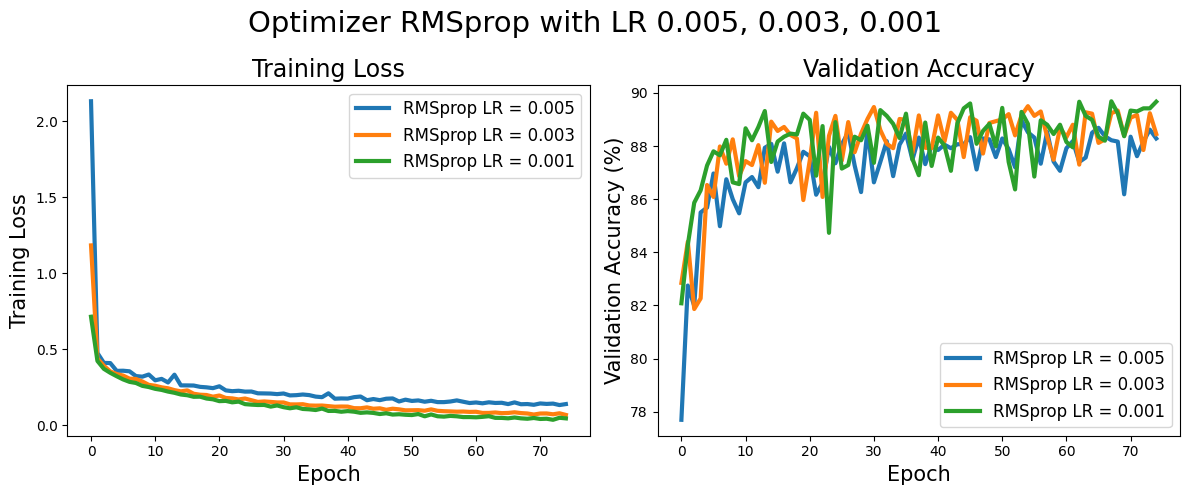

In [117]:
plot_param(train_loss_optmR, val_acc_optmR, lr_optmR, "OPTM", f"{optimizerR} LR", "Optimizer RMSprop with LR 0.005, 0.003, 0.001")

In [15]:
lr_optmA = [0.01, 0.005, 0.001]
optimizerA = "Adam"

# Run experiments for Adam optimizer

print(f"\n Running experiments for optimizer: {optimizerA}")

train_loss_optmA, val_acc_optmA, test_acc_optmA, test_std_optmA = run_param(
    train_batches, val_batches, test_batches, 
    param_name="learning_rate", param_values=lr_optmA, dropout_rate=0,
    optimizer_type=optimizerA, epochs=75, hidden_layers=[256, 128, 64])


# Print test accuracy for each learning rate
print(f"\nTest Accuracies for {optimizerA}:")
for lr, test_acc, test_std in zip(lr_optmA, test_acc_optmA, test_std_optmA):
    print(f"Learning Rate {lr}: Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")


 Running experiments for optimizer: Adam

Running experiment with learning_rate = 0.01


100%|██████████| 75/75 [03:55<00:00,  3.14s/it]



Running experiment with learning_rate = 0.005


100%|██████████| 75/75 [03:54<00:00,  3.13s/it]



Running experiment with learning_rate = 0.001


100%|██████████| 75/75 [03:55<00:00,  3.14s/it]



Test Accuracies for Adam:
Learning Rate 0.01: Test Accuracy: 0.8816 ± 0.0188
Learning Rate 0.005: Test Accuracy: 0.8906 ± 0.0198
Learning Rate 0.001: Test Accuracy: 0.8835 ± 0.0209


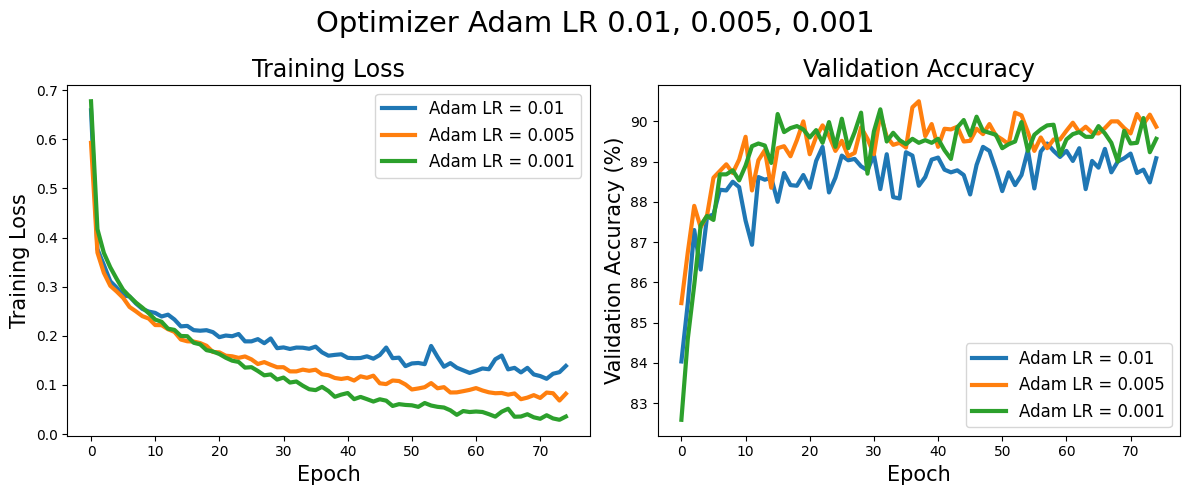

In [17]:
plot_param(train_loss_optmA, val_acc_optmA, lr_optmA, "OPTM", f"{optimizerA} LR", "Optimizer Adam LR 0.01, 0.005, 0.001")

## Task 3.2: Dropout Regularization

In [18]:
dropouts = [0.0, 0.3]
train_loss_drop, val_acc_drop, test_acc_drop, val_loss_drop, test_std_drop = run_param(
    train_batches, val_batches, test_batches, 
    param_name="dropout_rate", param_values=dropouts,
    epochs=75, hidden_layers=[256, 128, 64], track_val_loss=True)


print("Test Accuracies for different dropouts:")
for drop, test_acc, test_std in zip(dropouts, test_acc_drop, test_std_drop):
    print(f"Dropouts {drop}: Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")



Running experiment with dropout_rate = 0.0


100%|██████████| 75/75 [03:56<00:00,  3.15s/it]



Running experiment with dropout_rate = 0.3


100%|██████████| 75/75 [04:00<00:00,  3.21s/it]


Test Accuracies for different dropouts:
Dropouts 0.0: Test Accuracy: 0.8749 ± 0.0275
Dropouts 0.3: Test Accuracy: 0.8859 ± 0.0207


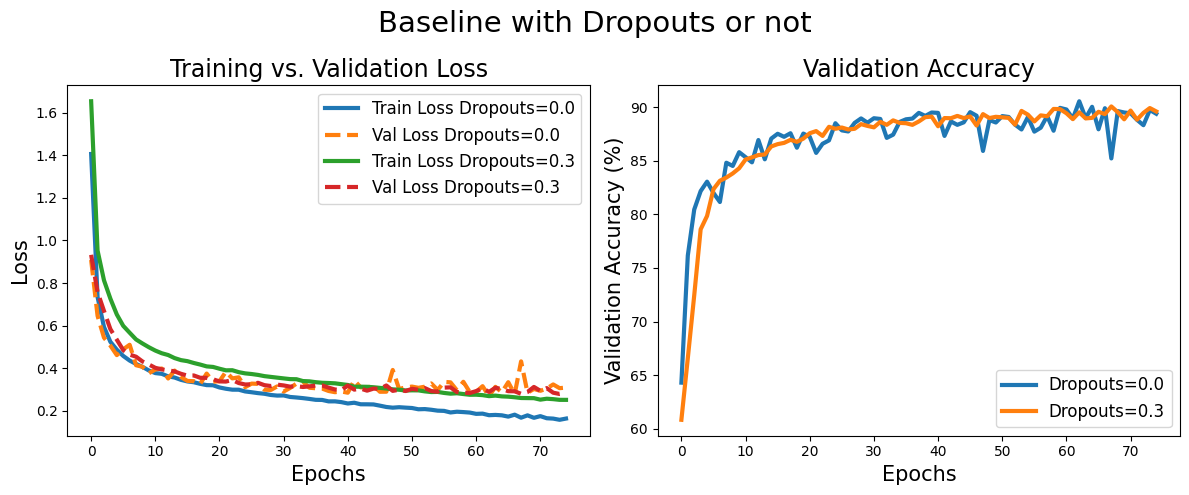

In [74]:
plot_train_val_loss(train_loss_drop, val_acc_drop, val_loss_drop, dropouts, 'DROP_analysis', "Dropouts", "Baseline with Dropouts or not")

## Task 3.3: Different Initializations

In [42]:
inits = ['xavier', 'kaiming', 'normal']

train_loss_init, val_acc_init, test_acc_init, test_std_init = run_param(
    train_batches, val_batches, test_batches, 
    param_name="init_type", param_values=inits,
    epochs=75, hidden_layers=[256, 128, 64])

print("Test Accuracies for different learning rates:")
for init, test_acc, test_std in zip(inits, test_acc_init, test_std_init):
    print(f"Initialization {init}: Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")


Running experiment with init_type = xavier


100%|██████████| 75/75 [03:50<00:00,  3.08s/it]



Running experiment with init_type = kaiming


100%|██████████| 75/75 [03:50<00:00,  3.07s/it]



Running experiment with init_type = normal


100%|██████████| 75/75 [03:50<00:00,  3.08s/it]


Test Accuracies for different learning rates:
Initialization xavier: Test Accuracy: 0.8871 ± 0.0215
Initialization kaiming: Test Accuracy: 0.8878 ± 0.0207
Initialization normal: Test Accuracy: 0.8723 ± 0.0210


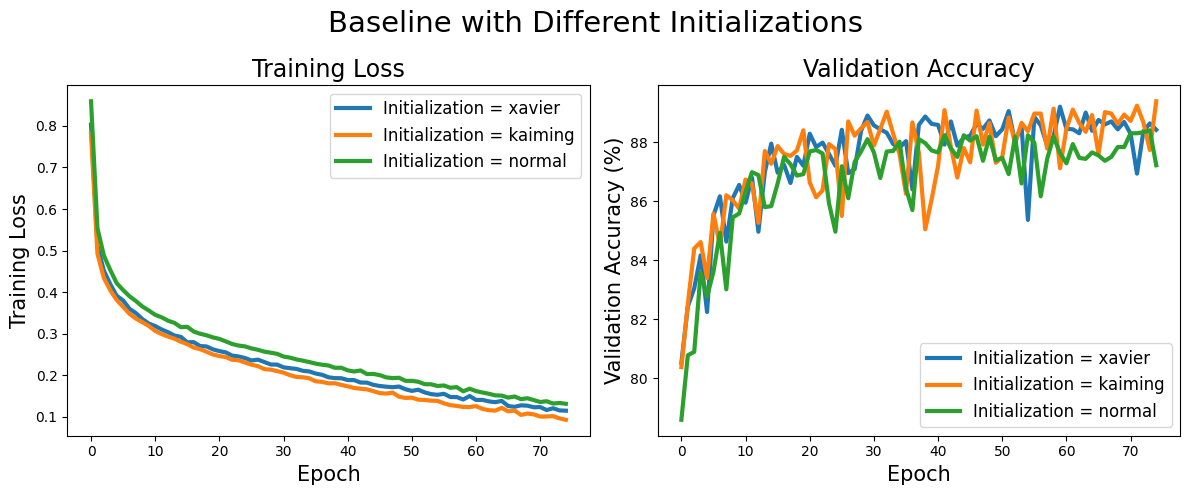

In [44]:
plot_param(train_loss_init, val_acc_init, inits, 'INIT', "Initialization", "Baseline with Different Initializations")

## Task 3.4: Batch Normalization

In [21]:
# Batch Normalization
Batch = [True, False]

train_loss_bn, val_acc_bn, test_acc_bn, test_std_bn = run_param(
    train_batches, val_batches, test_batches, 
    param_name="use_bn", param_values=Batch,
    epochs=75, hidden_layers=[256, 128, 64])

print("Test Accuracies for whether using Batch Normalization:")
for bn, test_acc, test_std in zip(Batch, test_acc_bn, test_std_bn):
    print(f"Use_bn={bn}: Test Accuracy: {test_acc:.4f} ± {test_std:.4f}")


Running experiment with use_bn = True


100%|██████████| 75/75 [03:53<00:00,  3.12s/it]



Running experiment with use_bn = False


100%|██████████| 75/75 [03:50<00:00,  3.07s/it]


Test Accuracies for whether using Batch Normalization:
Use_bn=True: Test Accuracy: 0.8900 ± 0.0273
Use_bn=False: Test Accuracy: 0.8751 ± 0.0195


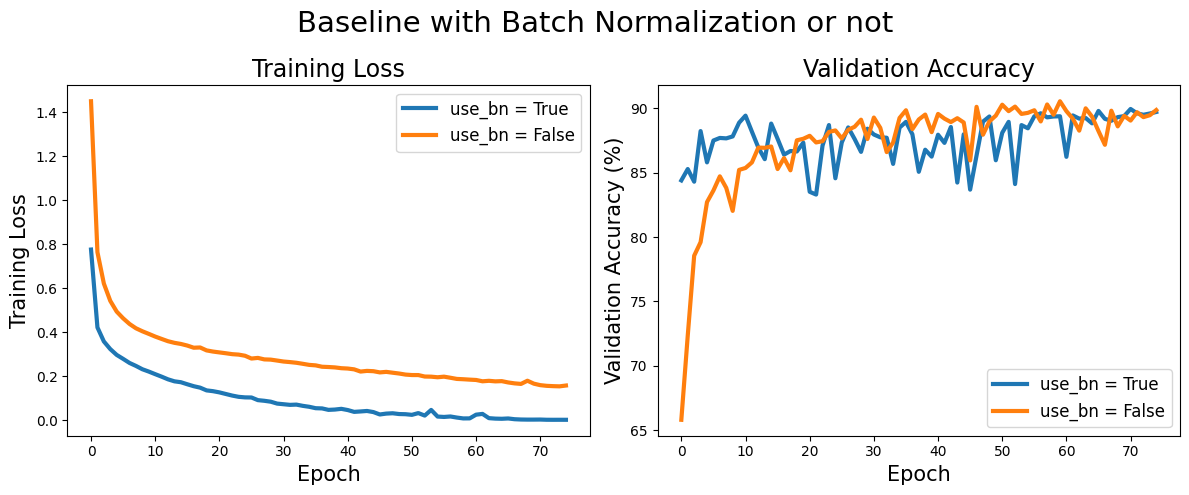

In [118]:
plot_param(train_loss_bn, val_acc_bn, Batch, 'BN', "use_bn", "Baseline with Batch Normalization or not")

## Task 4: Hyperparameter Tuning to Achieve High Testing Accuracy

### FashionMNIST > 90%

In [28]:
train_loss_config, val_acc_config, test_info_config = train_and_evaluate_FCN(train_batches, val_batches, test_batches, 
                           input_dim=784, output_dim=10, hidden_layers=[600, 300], 
                           init_type='xavier', optimizer_type="Adam", dropout_rate=0.3,
                           learning_rate=0.001, epochs=125)
test_acc_config, test_std_config = test_info_config

print(f"Test Accuracy: {test_acc_config:.4f} ± {test_std_config:.4f}")

100%|██████████| 125/125 [07:23<00:00,  3.55s/it]


Test Accuracy: 0.9024 ± 0.0161


-----load data for MNIST-----

In [ ]:
# Use the following code to load and normalize the MNIST dataset for training and testing
import struct
from torch.utils.data import Dataset, DataLoader, random_split

def load_data(filename):
    with open(filename, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, 1, rows, cols)
        return images

def load_label(filename):
    with open(filename, 'rb') as f:
        _, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8) 
        return labels

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32) / 255.0 
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_images = load_data(filename='data/MNIST/raw/train-images.idx3-ubyte')
test_images = load_data(filename='data/MNIST/raw/t10k-images.idx3-ubyte')
train_labels = load_label(filename='data/MNIST/raw/train-labels.idx1-ubyte')
test_labels = load_label(filename='data/MNIST/raw/t10k-labels.idx1-ubyte')

mnist_transform = torchvision.transforms.Compose([torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = MNISTDataset(train_images, train_labels, transform=mnist_transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=mnist_transform)

# Split training into train & validation (10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_split, val_split = random_split(train_dataset, [train_size, val_size])

# Set batch sizes
train_batch_size = 512
test_batch_size = 256

mnist_train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
mnist_val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=False)
mnist_test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(f"Train Batches: {len(mnist_train_batches)}")
print(f"Validation Batches: {len(mnist_val_batches)}")
print(f"Test Batches: {len(mnist_test_batches)}")

Train Batches: 106
Validation Batches: 12
Test Batches: 40


### MNIST > 98%

In [30]:
# Train the FCN model on MNIST
train_loss_mnist, val_acc_mnist, test_info_mnist = train_and_evaluate_FCN(
    mnist_train_batches, mnist_val_batches, mnist_test_batches,  
    input_dim=784, output_dim=10, hidden_layers=[600, 300], 
    init_type="xavier", optimizer_type="Adam", dropout_rate=0.3, 
    learning_rate=0.001, epochs=125)
test_acc_mnist, test_std_mnist = test_info_mnist

print(f"Test Accuracy: {test_acc_mnist:.4f} ± {test_std_mnist:.4f}")

100%|██████████| 125/125 [04:19<00:00,  2.07s/it]


Test Accuracy: 0.9848 ± 0.0101


### KNN on FashionMNIST

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

pca = PCA()
fashion_train_pca = pca.fit_transform(fashion_train_images)
fashion_test_pca = pca.transform(fashion_test_images)

Knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
Knn.fit(fashion_train_pca, fashion_train_labels)
# cv_score = cross_val_score(Knn, fashion_train_pca, fashion_train_labels, cv=5)  # 5-fold CV
# train_score = Knn.score(fashion_train_pca, fashion_train_labels)
# test_score = Knn.score(fashion_test_pca, fashion_test_labels)

fashion_test_acc = Knn.predict(fashion_test_pca)
test_acc_score = accuracy_score(fashion_test_labels, fashion_test_acc)

print(f"KNN Accuracy: {test_acc_score * 100:.2f}%")
# print(f"KNN Classifier CV Accuracy: {cv_score.mean():.4f} ± {cv_score.std():.4f}")
# print(f"\t Train Accuracy: {train_score:.4f}\n \t Test Accuracy: {test_score:.4f}")


KNN Accuracy: 85.54%
KNN Classifier CV Accuracy: 0.8540 ± 0.0037
	 Train Accuracy: 0.8998
 	 Test Accuracy: 0.8554


### --------------------------------Test Code--------------------------------------

In [ ]:
# #Define your (As Cool As It Gets) Fully Connected Neural Network 
# class testFCN(nn.Module):
#     #Initialize model layers, add additional arguments to adjust
#     def __init__(self, input_dim, output_dim, hidden_layers): 
#         super(testFCN, self).__init__()
#         #Define the network layer(s) and activation function(s)
#         self.input_layer = nn.Linear(input_dim, hidden_layers[0])
#         self.hidden_layers = nn.ModuleList()
#         for i in range(len(hidden_layers) - 1):
#             self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
#         self.output_layer = nn.Linear(hidden_layers[-1], output_dim)
 
#     def forward(self, input):
#         #Define how your model propagates the input through the network
#         input = input.view(input.shape[0], -1)
#         x = torch.nn.functional.relu(self.input_layer(input))
#         for layer in self.hidden_layers:
#             x = torch.nn.functional.relu(layer(x))
#         output = self.output_layer(x)
        
#         return output


In [ ]:
# # Initialize neural network model with input, output and hidden layer dimensions
# model = ACAIGFCN(input_dim = 784, output_dim = 10, hidden_layers=[600, 300], init_type='xavier', dropout_rate=0.3)

# # Define the learning rate and epochs number
# learning_rate = 0.001
# epochs = 30


# train_loss_list = np.zeros((epochs,))
# val_accuracy_list = np.zeros((epochs,))
# val_loss_list = np.zeros((epochs,))

# # Define loss function and optimizer
# loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 

# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Use optimizers from torch.optim
# # optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
# # Track the loss and validation accuracy
# for epoch in tqdm.trange(epochs):

#     # ACAIGFCN Training 
#     epoch_loss = 0.0
#     for train_features, train_labels in train_batches:
#         # Set model into training mode
#         model.train()
        
#         # Reshape images into a vector
#         train_features = train_features.reshape(-1, 28*28)

#         # Reset gradients, Calculate training loss on model 
#         optimizer.zero_grad()
#         outputs = model(train_features)
#         loss = loss_func(outputs, train_labels)

#         # Perfrom optimization, back propagation
#         loss.backward()
#         optimizer.step()
        
#         # Accumulate the loss for the epoch
#         epoch_loss += loss.item()

 
#     # Record loss for the epoch
#     train_loss_list[epoch] = epoch_loss / len(train_batches)
#     # print('Epoch {}, loss {}'.format(epoch, loss.item()))

#     # ACAIGFCN Validation
#     val_loss = 0.0
#     correct_predictions = 0
#     total_samples = 0
#     for val_features, val_labels in val_batches:
        
#         # Telling PyTorch we aren't passing inputs to network for training purpose
#         with torch.no_grad(): 
#             model.eval()
            
#              # Reshape validation images into a vector
#             val_features = val_features.reshape(-1, 28*28)
          
#             # Compute validation outputs (targets) and compute accuracy 
#             val_outputs = model(val_features)

#             # Compute validation accuracy
#             loss = loss_func(val_outputs, val_labels)
#             val_loss += loss.item()

#         # Compute accuracy in a concise manner
#         correct = (torch.argmax(val_outputs, dim=1) == val_labels).float()
        
#         # Accumulate correct predictions and total samples
#         correct_predictions += correct.sum().item()
#         total_samples += val_labels.size(0)

#     # Compute and record validation accuracy
#     val_accuracy_list[epoch] = correct_predictions / total_samples
#     # Store average validation loss
#     val_loss_list[epoch] = val_loss / len(val_batches)
            
#     # Record accuracy for the epoch; print training loss, validation accuracy
#     # print(f"Epoch: {epoch}; Validation Accuracy: {val_accuracy_list[epoch] * 100:.2f}%")



100%|██████████| 30/30 [01:52<00:00,  3.76s/it]


In [ ]:
# #Calculate accuracy on test set

# # Telling PyTorch we aren't passing inputs to network for training purpose
# with torch.no_grad():
#     test_correct = 0
#     total_test = 0
#     batch_accuracies = []
#     for test_features, test_labels in test_batches:

#         model.eval()
#         # Reshape test images into a vector
#         test_features = test_features.reshape(-1, 28*28)

#         # Compute validation outputs (targets) 
#         test_outputs = model(test_features)
#         correct1 = (torch.argmax(test_outputs, dim=1) == test_labels).float()
#         batch_acc = correct1.mean().item()  # Accuracy for this batch
#         batch_accuracies.append(batch_acc)
        
#         # Accumulate correct predictions and total samples
#         test_correct += correct1.sum().item()
#         total_test += test_labels.size(0)
    
#     # Compute total (mean) accuracy
#     test_acc = test_correct / total_test
#     test_acc_std = np.std(batch_accuracies)
    
#     # Report total (mean) accuracy, can also compute std based on batches
#     print(f"Test Accuracy: {test_acc} ± {test_acc_std:.4f}")


Test Accuracy: 0.8958 ± 0.0193


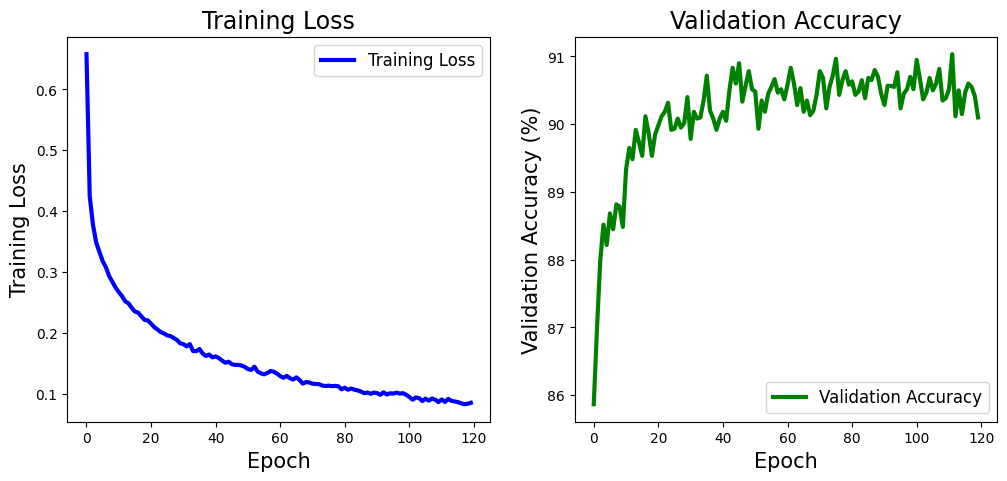

In [ ]:
# # Plot training loss and validation accuracy throughout the training epochs
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_loss_list, linewidth=3, color='blue', label="Training Loss")
# plt.xlabel("Epoch", fontdict=dict(size=15))
# plt.ylabel("Training Loss", fontdict=dict(size=15))
# plt.title("Training Loss", fontdict=dict(size=17))
# plt.legend(fontsize=12)
# plt.subplot(1, 2, 2)
# plt.plot(val_accuracy_list * 100, linewidth=3, color='g', label="Validation Accuracy")
# plt.xlabel("Epoch", fontdict=dict(size=15))
# plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
# plt.title("Validation Accuracy", fontdict=dict(size=17))
# plt.legend(fontsize=12)
# plt.savefig(f'test.pdf')
# plt.show()

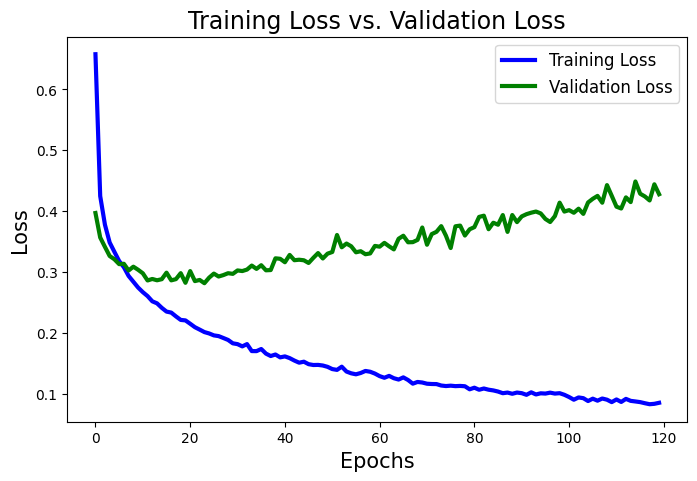

In [ ]:
# def plot_train_val_loss(train_loss, val_loss):
#     plt.figure(figsize=(8, 5))
#     plt.plot(train_loss, linewidth=3, color='blue', label="Training Loss")
#     plt.plot(val_loss, linewidth=3, color='green', label="Validation Loss")
#     plt.xlabel("Epochs", fontdict=dict(size=15))
#     plt.ylabel("Loss", fontdict=dict(size=15))
#     plt.legend(fontsize=12)
#     plt.title("Training Loss vs. Validation Loss", fontdict=dict(size=17))
#     plt.show()
# plot_train_val_loss(train_loss_list, val_loss_list)


Running experiment with hidden_layers = [256, 128, 64, 32]


100%|██████████| 30/30 [01:33<00:00,  3.13s/it]



Running experiment with hidden_layers = [256, 128, 64]


100%|██████████| 30/30 [01:33<00:00,  3.12s/it]



Running experiment with hidden_layers = [256, 128]


100%|██████████| 30/30 [01:32<00:00,  3.09s/it]


Test Accuracies for different learning rates:
Hidden Layers [256, 128, 64, 32]: Test Accuracy = 86.07%
Hidden Layers [256, 128, 64]: Test Accuracy = 88.16%
Hidden Layers [256, 128]: Test Accuracy = 86.73%


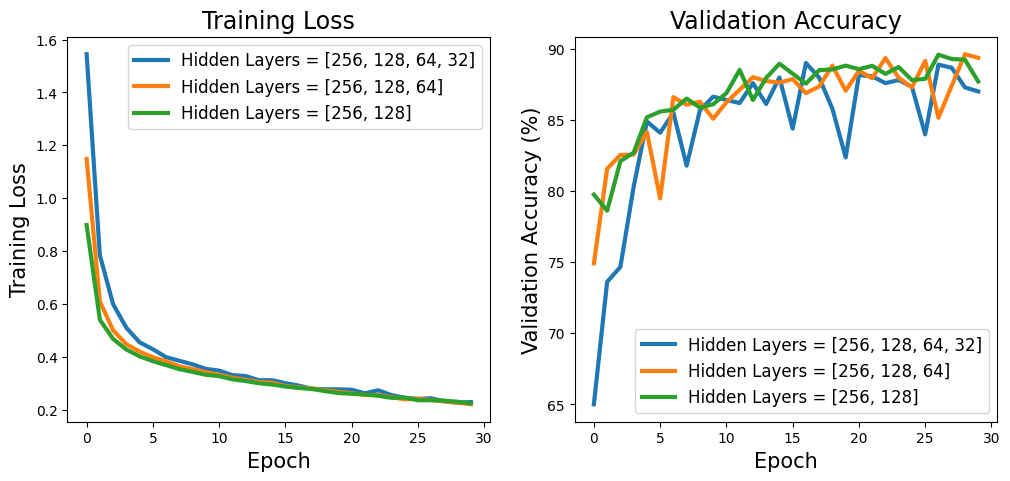

In [ ]:
# # Differernt hidden layers
# hl_values = [[256, 128, 64, 32], [256, 128, 64], [256, 128]]
# train_loss_hl, val_acc_hl, test_acc_hl = run_param(
#     train_batches, val_batches, test_batches,
#     param_name="hidden_layers", param_values=hl_values, 
#     learning_rate=0.1, epochs=30)

# print("Test Accuracies for different learning rates:")
# for hl, test_acc in zip(hl_values, test_acc_hl):
#     print(f"Hidden Layers {hl}: Test Accuracy = {test_acc*100:.2f}%")

# plot_param(train_loss_hl, val_acc_hl, hl_values, "Hidden Layers", "HL")


Running experiment with hidden_layers = [512, 256, 128]


100%|██████████| 30/30 [01:37<00:00,  3.24s/it]



Running experiment with hidden_layers = [256, 128, 64]


100%|██████████| 30/30 [01:33<00:00,  3.12s/it]



Running experiment with hidden_layers = [128, 64, 32]


100%|██████████| 30/30 [01:30<00:00,  3.03s/it]


Test Accuracies for different learning rates:
Hidden Layers [512, 256, 128]: Test Accuracy = 87.84%
Hidden Layers [256, 128, 64]: Test Accuracy = 88.18%
Hidden Layers [128, 64, 32]: Test Accuracy = 86.58%


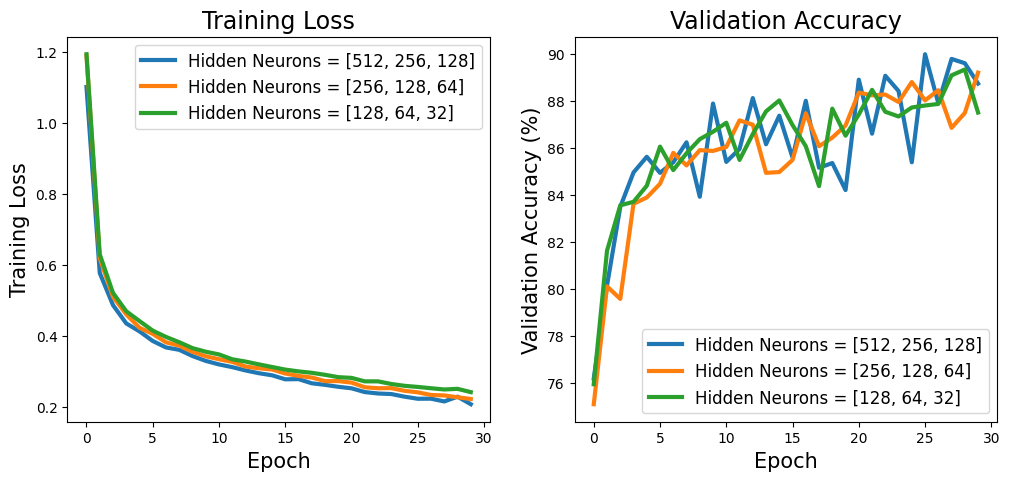

In [ ]:
# # Differernt hidden neurons
# hn_values = [[512, 256, 128], [256, 128, 64], [128, 64, 32]]
# train_loss_hn, val_acc_hn, test_acc_hn = run_param(
#     train_batches, val_batches, test_batches,
#     param_name="hidden_layers", param_values=hn_values, 
#     learning_rate=0.1, epochs=30)

# print("Test Accuracies for different learning rates:")
# for hn, test_acc in zip(hn_values, test_acc_hn):
#     print(f"Hidden Layers {hn}: Test Accuracy = {test_acc*100:.2f}%")

# plot_param(train_loss_hn, val_acc_hn, hn_values, "Hidden Neurons", "HN3")


Running experiment with hidden_layers = [512, 256]


100%|██████████| 30/30 [01:36<00:00,  3.21s/it]



Running experiment with hidden_layers = [256, 128]


100%|██████████| 30/30 [01:32<00:00,  3.09s/it]



Running experiment with hidden_layers = [128, 64]


100%|██████████| 30/30 [01:30<00:00,  3.02s/it]



Running experiment with hidden_layers = [64, 32]


100%|██████████| 30/30 [01:29<00:00,  3.00s/it]


Test Accuracies for different learning rates:
Hidden Layers [512, 256]: Test Accuracy = 87.76%
Hidden Layers [256, 128]: Test Accuracy = 87.82%
Hidden Layers [128, 64]: Test Accuracy = 86.71%
Hidden Layers [64, 32]: Test Accuracy = 86.78%


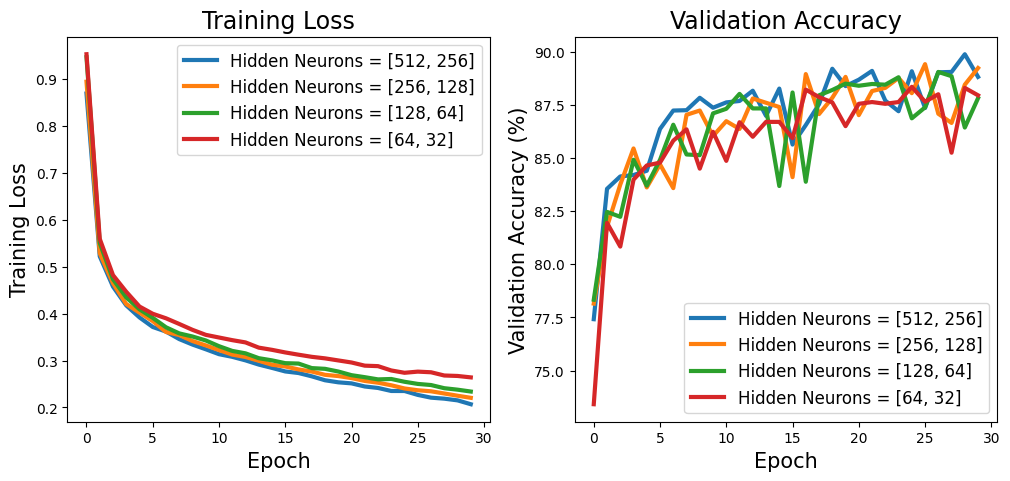

In [ ]:
# # Differernt hidden neurons
# hn_values = [[512, 256], [256, 128], [128, 64], [64, 32]]
# train_loss_hn, val_acc_hn, test_acc_hn = run_param(
#     train_batches, val_batches, test_batches,
#     param_name="hidden_layers", param_values=hn_values, 
#     learning_rate=0.1, epochs=30)

# print("Test Accuracies for different learning rates:")
# for hn, test_acc in zip(hn_values, test_acc_hn):
#     print(f"Hidden Layers {hn}: Test Accuracy = {test_acc*100:.2f}%")

# plot_param(train_loss_hn, val_acc_hn, hn_values, "Hidden Neurons", "HN")


Running experiment with learning_rate = 0.01


100%|██████████| 30/30 [01:33<00:00,  3.11s/it]



Running experiment with learning_rate = 0.05


100%|██████████| 30/30 [01:34<00:00,  3.15s/it]



Running experiment with learning_rate = 0.1


100%|██████████| 30/30 [01:32<00:00,  3.10s/it]



Running experiment with learning_rate = 0.15


100%|██████████| 30/30 [01:32<00:00,  3.09s/it]


Test Accuracies for different learning rates:
Learning Rate 0.01: Test Accuracy = 83.53%
Learning Rate 0.05: Test Accuracy = 86.11%
Learning Rate 0.1: Test Accuracy = 88.35%
Learning Rate 0.15: Test Accuracy = 88.57%


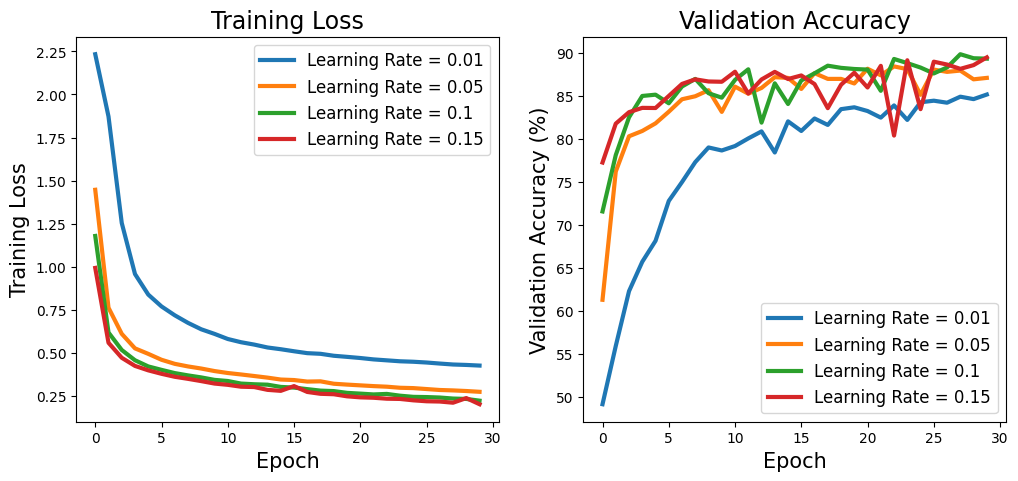

In [ ]:
# # Different learning rates
# lr_values = [0.01, 0.05, 0.1, 0.15]
# train_loss_lr, val_acc_lr, test_acc_lr = run_param(
#     train_batches, val_batches, test_batches,
#     param_name="learning_rate", param_values=lr_values, 
#     hidden_layers=[256, 128, 64], epochs=30)

# print("Test Accuracies for different learning rates:")
# for lr, test_acc in zip(lr_values, test_acc_lr):
#     print(f"Learning Rate {lr}: Test Accuracy = {test_acc*100:.2f}%")

# plot_param(train_loss_lr, val_acc_lr, lr_values, "Learning Rate", "LR3")


Running experiment with learning_rate = 0.01


100%|██████████| 30/30 [01:33<00:00,  3.12s/it]



Running experiment with learning_rate = 0.05


100%|██████████| 30/30 [01:33<00:00,  3.11s/it]



Running experiment with learning_rate = 0.1


100%|██████████| 30/30 [01:32<00:00,  3.08s/it]



Running experiment with learning_rate = 0.15


100%|██████████| 30/30 [01:32<00:00,  3.08s/it]


Test Accuracies for different learning rates:
Learning Rate 0.01: Test Accuracy = 84.20%
Learning Rate 0.05: Test Accuracy = 86.50%
Learning Rate 0.1: Test Accuracy = 87.48%
Learning Rate 0.15: Test Accuracy = 87.26%


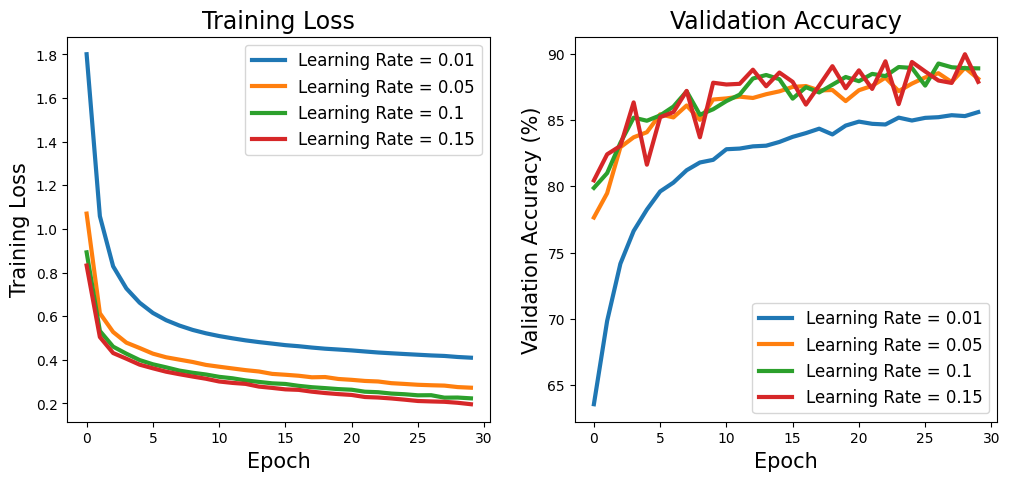

In [ ]:
# # Different learning rates
# lr_values = [0.01, 0.05, 0.1, 0.15]
# train_loss_lr, val_acc_lr, test_acc_lr = run_param(
#     train_batches, val_batches, test_batches,
#     param_name="learning_rate", param_values=lr_values, 
#     hidden_layers=[256, 128], epochs=30)

# print("Test Accuracies for different learning rates:")
# for lr, test_acc in zip(lr_values, test_acc_lr):
#     print(f"Learning Rate {lr}: Test Accuracy = {test_acc*100:.2f}%")

# plot_param(train_loss_lr, val_acc_lr, lr_values, "Learning Rate", "LR")